In [ ]:
pip install category_encoders

In [ ]:
!pip install scikit-optimize

# Import Libraries

In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1 - Explore and prep data

In [168]:
df = pd.read_csv("C:\\Users\\rmct2\\OneDrive - Sri Lanka Institute of Information Technology\\Desktop\\SLIIT\\Y3S1\\FDM\\car_prices.csv")

In [169]:
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

In [170]:
df['transmission'].fillna('automatic', inplace=True)

In [171]:
df = df.dropna(subset=['vin', 'state','sellingprice','saledate','make', 'model', 'trim','body','condition','odometer','color','interior','mmr'])

In [172]:
df.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr             float64
sellingprice    float64
saledate         object
dtype: object

In [173]:
# Select categorical columns 
categorical_columns = ['make','model','trim','body','transmission','vin','state','color','interior','seller','saledate']  

In [174]:
from category_encoders import TargetEncoder
# Create a copy of the dataframe
df_encoded = df.copy()

# Apply Target Encoding
encoder = TargetEncoder(cols=categorical_columns)
df_encoded[categorical_columns] = encoder.fit_transform(df[categorical_columns], df['mmr'])


In [175]:
# Compute the correlation matrix
correlation_matrix = df_encoded.corr(method='pearson')  

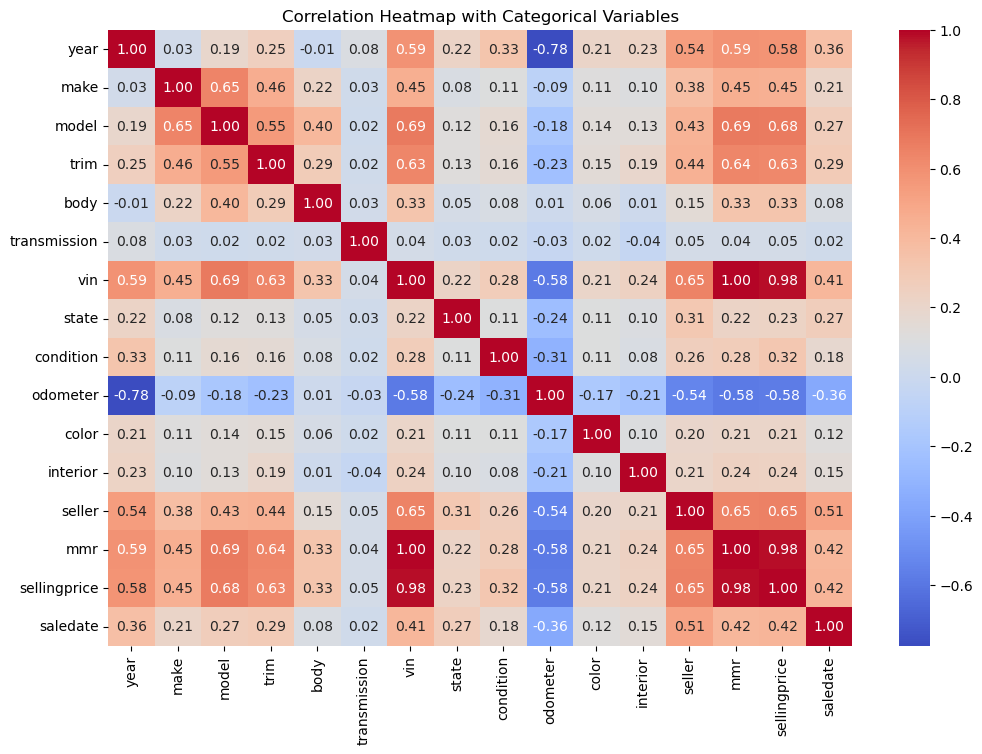

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap with Categorical Variables")
plt.show()


In [177]:
#list and drop columns that are less related to the target based on my judgement
cols_to_drop = ['transmission','color','interior','state','sellingprice','saledate','vin']

#at the same time rename the columns so they are understandable.
df = df.drop(columns = cols_to_drop).rename(columns = {'year':'manufacture_year','make':'brand','model':'specific_model',
                                                      'trim':'additional_designation','mmr':'estimated_value'})



In [178]:
df.head()

,manufacture_year,brand,specific_model,additional_designation,body,condition,odometer,seller,estimated_value
0,2015,Kia,Sorento,LX,SUV,5.0,16639.0,kia motors america inc,20500.0
1,2015,Kia,Sorento,LX,SUV,5.0,9393.0,kia motors america inc,20800.0
2,2014,BMW,3 Series,328i SULEV,Sedan,45.0,1331.0,financial services remarketing (lease),31900.0
3,2015,Volvo,S60,T5,Sedan,41.0,14282.0,volvo na rep/world omni,27500.0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,43.0,2641.0,financial services remarketing (lease),66000.0


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533648 entries, 0 to 558836
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   manufacture_year        533648 non-null  int64  
 1   brand                   533648 non-null  object 
 2   specific_model          533648 non-null  object 
 3   additional_designation  533648 non-null  object 
 4   body                    533648 non-null  object 
 5   condition               533648 non-null  float64
 6   odometer                533648 non-null  float64
 7   seller                  533648 non-null  object 
 8   estimated_value         533648 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 40.7+ MB


In [180]:
df.isnull().sum()

manufacture_year          0
brand                     0
specific_model            0
additional_designation    0
body                      0
condition                 0
odometer                  0
seller                    0
estimated_value           0
dtype: int64

In [181]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')


Number of duplicate rows: 7


In [182]:
df.drop_duplicates(inplace=True)

In [183]:
df.shape

(533641, 9)

In [184]:
Q1 = df['estimated_value'].quantile(0.25)
Q3 = df['estimated_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['estimated_value'] < lower_bound) | (df['estimated_value'] > upper_bound)]

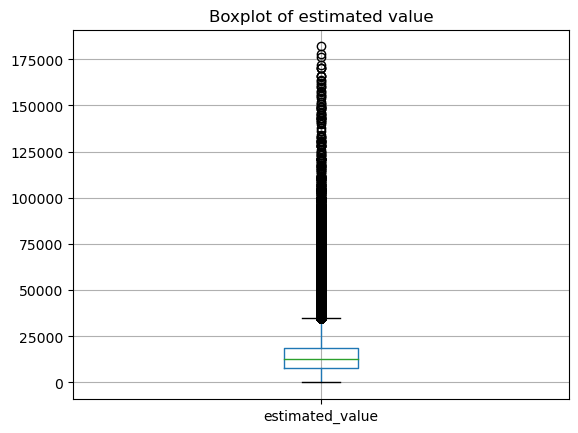

In [185]:
df[['estimated_value']].boxplot()
plt.title('Boxplot of estimated value')
plt.show()

In [186]:
df = df[(df['estimated_value'] >= lower_bound) & (df['estimated_value'] <= upper_bound)]

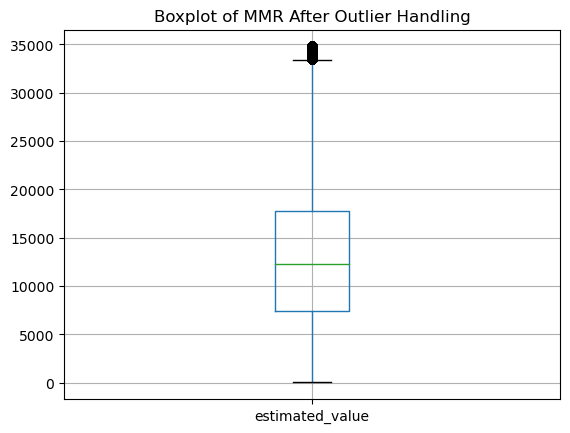

In [187]:
df[['estimated_value']].boxplot()
plt.title('Boxplot of MMR After Outlier Handling')
plt.show()

In [188]:
df.shape

(517493, 9)

In [189]:
#Split to training and testing

from sklearn.model_selection import train_test_split

x = df.drop(columns = 'estimated_value')
y = df['estimated_value']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2,random_state=8)

In [190]:
print(X_train.dtypes)

manufacture_year            int64
brand                      object
specific_model             object
additional_designation     object
body                       object
condition                 float64
odometer                  float64
seller                     object
dtype: object


# Step 2 - Build a pipeline of training

In [191]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor

estimators = [
    ('encoder', TargetEncoder()),  # Categorical encoding
    ('reg', XGBRegressor(random_state=8))  # Regression model for continuous target
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('reg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=8, ...))])

# Step 3 - Set up hyperparameter tuning

In [192]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'reg__n_estimators': (100, 1000),  # Number of trees
    'reg__max_depth': (3, 10),          # Maximum depth of trees
    'reg__learning_rate': (0.01, 0.3),  # Learning rate
    'reg__alpha': (0, 10),              # L1 regularization term
    'reg__lambda': (0, 10)              # L2 regularization term
}

# Perform Bayesian search over the pipeline
opt = BayesSearchCV(pipe, search_space, n_iter=50, scoring='neg_mean_squared_error', n_jobs=-1)

# Step 4 - Train the XGBoost Model

In [193]:
opt.fit(X_train, Y_train)

BayesSearchCV(estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      in...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=8, ...))]),
              n_jobs=-1, scoring='neg_mean_squared_error',
              search_spaces={'reg__alpha': (0, 10), 'reg__lambda': (0, 10),
                             'reg__learning_rate': (0.01, 0.3),
                             'reg__max_depth': (3, 10),
                             'reg__n_estimators': (100, 1000)})

In [194]:
# Train the model with the best parameters
best_model = opt.best_estimator_
best_model.fit(X_train, Y_train)

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['brand', 'specific_model',
                                     'additional_designation', 'body',
                                     'seller'])),
                ('reg',
                 XGBRegressor(alpha=0, base_score=None, booster=None,
                              callbacks=None, colsample_bylevel=None,
                              colsample_bynode=None, colsample_bytree=None,
                              device=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, lambda=0,
                              learning_rate=0.059197518006983744, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=1000,
                              n_jobs=None, ...))])

# Step 5 - Evaluate the model and make predictions

In [195]:
# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = -cv_scores.mean()  # Convert to positive
std_cv_score = cv_scores.std()

In [211]:
std_cv_score

13229.644005564747

In [199]:
predictions = opt.predict(X_train)

In [200]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Predictions from your model
predictions = opt.predict(X_train)

# Calculate R-squared
r2 = r2_score(Y_train, predictions)
print(f'R-squared for training data: {r2}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(Y_train, predictions)
print(f'Mean Absolute Error for training data: {mae}')


R-squared for training data: 0.9932444130612046
Mean Absolute Error for training data: 405.6155705745478


In [201]:
from sklearn.metrics import r2_score, mean_absolute_error

# Make predictions on the test set
predictions = opt.predict(X_test)

# Calculate R-squared on the test set
r2 = r2_score(Y_test, predictions)
print(f'R-squared on Test Data: {r2}')

# Calculate Mean Absolute Error on the test set
mae = mean_absolute_error(Y_test, predictions)
print(f'Mean Absolute Error on Test Data: {mae}')


R-squared on Test Data: 0.9828386789965422
Mean Absolute Error on Test Data: 587.3337457018013


In [208]:
input_data = {
    'manufacture_year': [2013],
    'brand': ['Kia'],
    'specific_model': ['Optima'],
    'additional_designation': ['EX Hybrid'],
    'body': ['Sedan'],
    'condition': [44],
    'odometer': [16045],
    'seller': ['kia motors america inc']
}

# Convert the input into a DataFrame
input_df = pd.DataFrame(input_data)

# Make a prediction with the trained pipeline
predicted_price = opt.predict(input_df)

# Output the prediction
print(f"Predicted Vehicle Price: {predicted_price[0]:.2f}")


Predicted Vehicle Price: 16510.59


# Step 6 - Measure feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

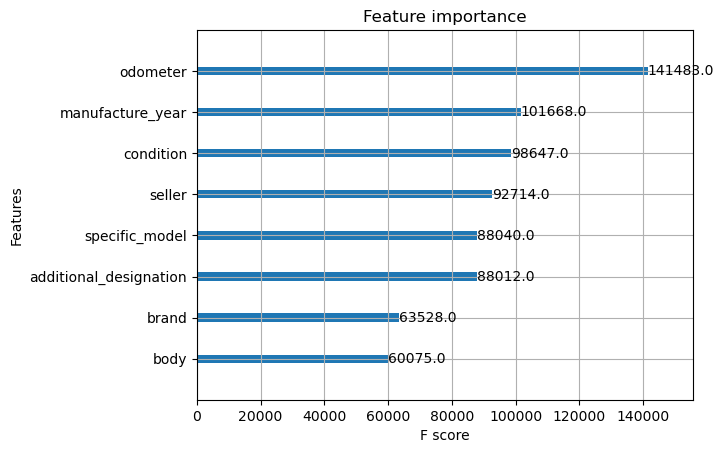

In [204]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)